# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].


plane


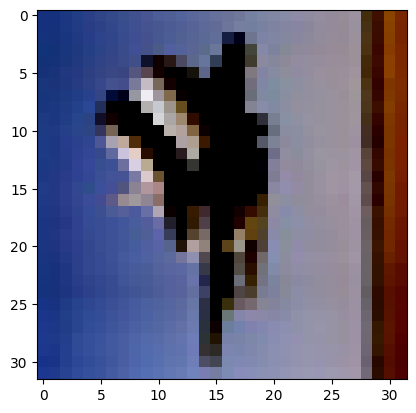

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9529412].


horse


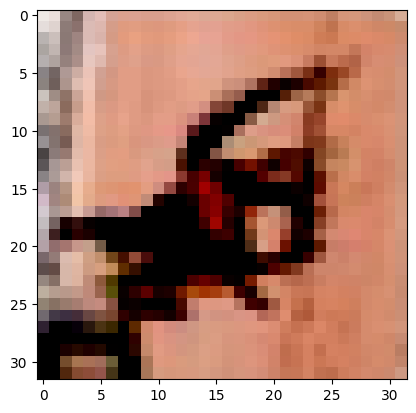

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


ship


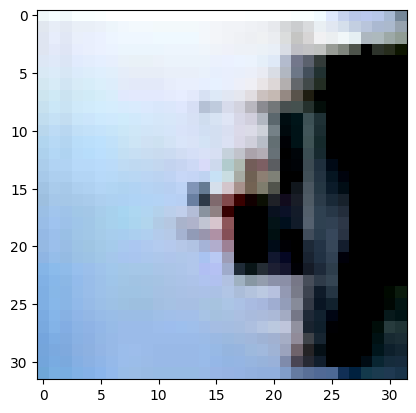

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.92941177].


dog


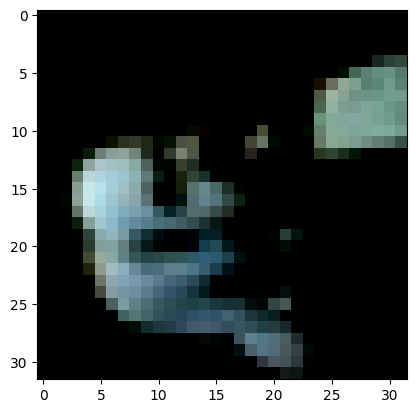

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.85882354].


frog


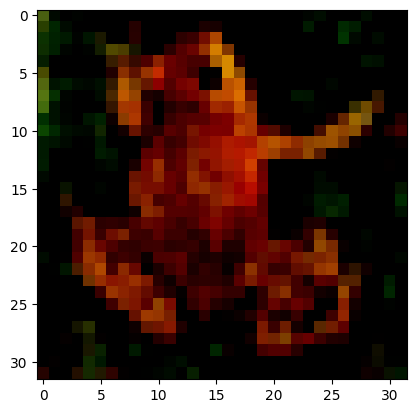

torch.Size([3, 32, 32])

In [4]:
# Explore data
show5(trainloader)

dataiter = iter(trainloader)
batch = next(dataiter)
image = batch[0][0]
image.size()

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
# OK, so since we're given free reign to use whatever architecture, BUT haven't REALLY been told how to do a convolutional neutral network
# I had to go use the PyTorch tutorial to figure out how to do this. (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
# I sort of smashed the two together to create this network.  I had to read up on how Conv2D worked to make sure this didn't blow up on me
# Also, paperswithcode is awesome, and this helped me understand what's going on here: https://paperswithcode.com/method/max-pooling

class HomeCIFAR(nn.Module):
    def __init__(self):
        super().__init__()

        # This convolutional layer 
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        self.pool = nn.MaxPool2d(2, 2)        

        # This is the second convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)

        # To get it back to linear, we need to multiply the out channels by the x and y of the stride
        # We use flatten here, which is like view but for both contiguous and non-contiguous data
        self.fc1 = nn.Linear(16 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # Since we have linear layers, it'd be good to use dropout here for edge cases
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # I don't know how the PyTorch classifier would work without a softmax here, so I put one.
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
model = HomeCIFAR()

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
# I'm going to call this again later in the accuracy section
def eval(model, loader, device):
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            
            log_ps = model(images)
            test_loss += criterion(log_ps.cpu(), labels.cpu())
            
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    return test_loss, accuracy

# OK, time for the training and evaluation loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# This actually worked out great.  100 iterations is very goldilocks and this shows where training plateaus.  If I picked
# 1000, I'd be very upset with myself.
epochs = batch_size

train_losses, test_losses, accuracies = [], [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss, accuracy = eval(model, testloader, device)
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        accuracies.append(accuracy/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracies[-1]))

Epoch: 1/100..  Training Loss: 2.303..  Test Loss: 2.302..  Test Accuracy: 0.100
Epoch: 2/100..  Training Loss: 2.301..  Test Loss: 2.299..  Test Accuracy: 0.116
Epoch: 3/100..  Training Loss: 2.297..  Test Loss: 2.290..  Test Accuracy: 0.193
Epoch: 4/100..  Training Loss: 2.272..  Test Loss: 2.228..  Test Accuracy: 0.169
Epoch: 5/100..  Training Loss: 2.179..  Test Loss: 2.113..  Test Accuracy: 0.205
Epoch: 6/100..  Training Loss: 2.090..  Test Loss: 2.024..  Test Accuracy: 0.222
Epoch: 7/100..  Training Loss: 2.008..  Test Loss: 1.940..  Test Accuracy: 0.245
Epoch: 8/100..  Training Loss: 1.946..  Test Loss: 1.892..  Test Accuracy: 0.266
Epoch: 9/100..  Training Loss: 1.904..  Test Loss: 1.854..  Test Accuracy: 0.294
Epoch: 10/100..  Training Loss: 1.852..  Test Loss: 1.790..  Test Accuracy: 0.334
Epoch: 11/100..  Training Loss: 1.779..  Test Loss: 1.687..  Test Accuracy: 0.376
Epoch: 12/100..  Training Loss: 1.722..  Test Loss: 1.647..  Test Accuracy: 0.391
Epoch: 13/100..  Training

Plot the training loss (and validation loss/accuracy, if recorded).

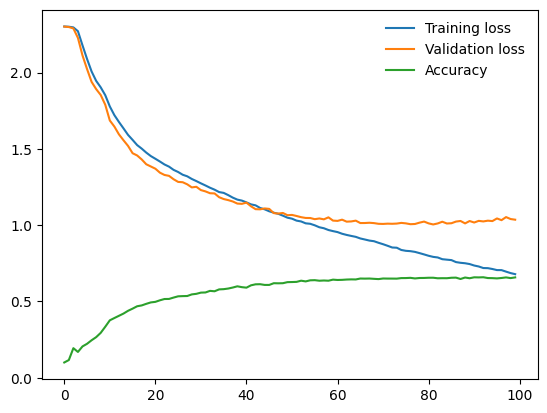

In [8]:
plt.plot(train_losses, label='Training loss')
# I got an error on the code because tests losses ended up on GPU
plt.plot(test_losses, label='Validation loss'),
plt.plot(accuracies, label='Accuracy')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
_, accuracy = eval(model, testloader, device)
print("Test Accuracy: {:.3f}".format(accuracies[-1]))

Test Accuracy: 0.658


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
PATH = "home_cifar.ckpt"
torch.save(model.state_dict, PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

This Neural Network was a combination of the Linear Layers used in the course material and the Tutorial on the PyTorch page that I found when I needed to figure out how to load the CIFAR-10 dataset.  Given that it only took 100 iterations and a couple of minutes to train this model and I was able to get 68% without even bothering to use transfer learning on an establed CNN like ResNet or MobileNet, which are free, I'm going to suggest that build may be greater than buy.  It's clear that the mention of convolution was the hint here and that combining convolution with the techniques in the course led us here, since the PyTorch documention indicates that Convolution alone without dropout only got to 53%.

I tried adding more linear layers to see if I could improve accuracy, but that did basically nothing and it held at around 65%  I have no idea if dropout works with conv2d layers.  